<a href="https://colab.research.google.com/github/NethmiAmasha/Edge-Detection-with-Mamba/blob/main/EDMB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Li-yachuan/EDMB.git
%cd /content/EDMB
!ls -la  # Verify files

Cloning into 'EDMB'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 128 (delta 56), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (128/128), 714.48 KiB | 2.98 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/EDMB
total 96
drwxr-xr-x 6 root root  4096 Oct 17 13:25 .
drwxr-xr-x 1 root root  4096 Oct 17 13:25 ..
-rw-r--r-- 1 root root 21817 Oct 17 13:25 data_process.py
drwxr-xr-x 2 root root  4096 Oct 17 13:25 eval_muge_best
drwxr-xr-x 2 root root  4096 Oct 17 13:25 fig
-rw-r--r-- 1 root root  1109 Oct 17 13:25 gflops.py
drwxr-xr-x 8 root root  4096 Oct 17 13:25 .git
-rw-r--r-- 1 root root 11606 Oct 17 13:25 main.py
drwxr-xr-x 2 root root  4096 Oct 17 13:25 model
-rw-r--r-- 1 root root  5630 Oct 17 13:25 README.md
-rw-r--r-- 1 root root  2628 Oct 17 13:25 requirements.txt
-rw-r--r-- 1 root root 11251 Oct 17 13:25 test.py
-rw-r--r-- 1 root root  3649 O

In [2]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
!pip install git+https://github.com/Dao-AILab/causal-conv1d.git@v1.1.1

  Cloning https://github.com/Dao-AILab/causal-conv1d.git (to revision v1.1.1) to /tmp/pip-req-build-yuy2utyu
  Running command git clone --filter=blob:none --quiet https://github.com/Dao-AILab/causal-conv1d.git /tmp/pip-req-build-yuy2utyu
  Running command git checkout -q 97711965f6ea028d9fd4fe94e4e490b7c1011e11
  Resolved https://github.com/Dao-AILab/causal-conv1d.git to commit 97711965f6ea028d9fd4fe94e4e490b7c1011e11
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.5/446.5 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 

In [1]:
!pip install mamba-ssm==1.0.0 --no-build-isolation --no-cache-dir

ERROR: Could not find a version that satisfies the requirement mamba-ssm==1.0.0 (from versions: 1.0.1, 1.1.0, 1.1.1, 1.1.2, 1.1.3.post1, 1.1.4, 1.2.0, 1.2.0.post1, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.2.0, 2.2.1, 2.2.2, 2.2.3.post2, 2.2.4, 2.2.5, 2.2.6.post3)
ERROR: No matching distribution found for mamba-ssm==1.0.0


In [2]:
!pip install numpy opencv-python matplotlib tqdm

In [3]:
!pip install causal-conv1d>=1.2.0

In [4]:
!pip install mamba-ssm==1.1.0 --no-build-isolation --no-cache-dir

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for mamba-ssm
  Running setup.py clean for mamba-ssm
Failed to build mamba-ssm
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (mamba-ssm)


In [5]:
import torch
import torch.nn as nn

class SimpleSSM(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=4):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.A = nn.Parameter(torch.randn(d_state, d_state))
        self.B = nn.Linear(d_model, d_state)
        self.C = nn.Linear(d_state, d_model)
        self.conv = nn.Conv1d(d_model, d_model, kernel_size=d_conv, padding=d_conv-1, groups=d_model)

    def forward(self, x):
        delta = 0.1  # Simplified step size
        A_disc = torch.exp(delta * self.A)
        B_disc = (delta * self.A).matrix_exp() * (delta * self.B(x))  # Approx discretization
        h = torch.zeros(x.size(0), self.d_state, device=x.device)
        y = []
        for t in range(x.size(1)):
            h = A_disc @ h + B_disc[:, t, :]
            y.append(self.C(h))
        y = torch.stack(y, dim=1)
        return y + self.conv(x.transpose(1,2)).transpose(1,2)

class SimpleVisionMamba(nn.Module):
    def __init__(self, img_size=224, patch_size=16, d_model=256):
        super().__init__()
        self.patch_embed = nn.Conv2d(3, d_model, patch_size, stride=patch_size)
        self.ssm = SimpleSSM(d_model)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.patch_embed(x).flatten(2).transpose(1,2)
        x = self.ssm(x)
        x = self.norm(x.mean(1))
        return x.unsqueeze(-1).unsqueeze(-1)

In [6]:
!python -c "import torch; print('PyTorch:', torch.__version__); print('CUDA available:', torch.cuda.is_available()); import cv2; print('OpenCV:', cv2.__version__)"

PyTorch: 2.8.0+cu126
CUDA available: True
OpenCV: 4.12.0


In [11]:
!git clone https://github.com/BIDS/BSDS500.git
!ls -la /content/BSDS500  # Verify contents

Cloning into 'BSDS500'...
remote: Enumerating objects: 2380, done.
remote: Total 2380 (delta 0), reused 0 (delta 0), pack-reused 2380 (from 1)
Receiving objects: 100% (2380/2380), 155.21 MiB | 33.32 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files: 100% (2268/2268), done.
total 32
drwxr-xr-x 7 root root 4096 Oct 17 13:39 .
drwxr-xr-x 1 root root 4096 Oct 17 13:39 ..
drwxr-xr-x 5 root root 4096 Oct 17 13:39 bench
drwxr-xr-x 4 root root 4096 Oct 17 13:39 BSDS500
drwxr-xr-x 2 root root 4096 Oct 17 13:39 documentation
drwxr-xr-x 8 root root 4096 Oct 17 13:39 .git
drwxr-xr-x 6 root root 4096 Oct 17 13:39 grouping
-rw-r--r-- 1 root root 1472 Oct 17 13:39 README.md


In [12]:
!pip install scipy

In [14]:
!ls -la /content/BSDS500/BSDS500/data
!ls -la /content/BSDS500/BSDS500/data/groundTruth/train | head -5
!ls -la /content/BSDS500/BSDS500/data/images/train | head -5

total 16
drwxr-xr-x 4 root root 4096 Oct 17 13:39 .
drwxr-xr-x 4 root root 4096 Oct 17 13:39 ..
drwxr-xr-x 5 root root 4096 Oct 17 13:39 groundTruth
drwxr-xr-x 5 root root 4096 Oct 17 13:39 images
total 9204
drwxr-xr-x 2 root root  4096 Oct 17 13:39 .
drwxr-xr-x 5 root root  4096 Oct 17 13:39 ..
-rwxr-xr-x 1 root root 52570 Oct 17 13:39 100075.mat
-rwxr-xr-x 1 root root 37390 Oct 17 13:39 100080.mat
total 14612
drwxr-xr-x 2 root root   4096 Oct 17 13:39 .
drwxr-xr-x 5 root root   4096 Oct 17 13:39 ..
-rwxr-xr-x 1 root root  75043 Oct 17 13:39 100075.jpg
-rwxr-xr-x 1 root root  40866 Oct 17 13:39 100080.jpg


In [15]:
import scipy.io as sio
import os
import cv2
import numpy as np

# Define paths based on the nested structure
base_dir = '/content/BSDS500/BSDS500/data/groundTruth'
output_base_dir = '/content/BSDS500/BSDS500/data/groundTruth_jpg'
os.makedirs(output_base_dir, exist_ok=True)

# Process each split (train, val, test)
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(base_dir, split)
    output_split_dir = os.path.join(output_base_dir, split)
    os.makedirs(output_split_dir, exist_ok=True)

    converted_count = 0
    for mat_file in os.listdir(split_dir):
        if mat_file.endswith('.mat'):
            mat_path = os.path.join(split_dir, mat_file)
            mat = sio.loadmat(mat_path)
            gt = mat['groundTruth'][0]  # Array of annotations
            for i, anno in enumerate(gt):
                boundaries = anno['Boundaries']  # Shape: (H, W, 1) - edge probabilities
                if boundaries.size > 0:
                    img = (boundaries.squeeze() * 255).astype(np.uint8)
                    cv2.imwrite(os.path.join(output_split_dir, f'{mat_file[:-4]}_{i}.jpg'), img)
                    converted_count += 1
    print(f"Converted {converted_count} annotations for {split} to {output_split_dir}")

print(f"Total conversions completed in {output_base_dir}")

Converted 1087 annotations for train to /content/BSDS500/BSDS500/data/groundTruth_jpg/train
Converted 546 annotations for val to /content/BSDS500/BSDS500/data/groundTruth_jpg/val
Converted 1063 annotations for test to /content/BSDS500/BSDS500/data/groundTruth_jpg/test
Total conversions completed in /content/BSDS500/BSDS500/data/groundTruth_jpg


In [16]:
!ls -la /content/BSDS500/BSDS500/data/groundTruth_jpg
!ls -la /content/BSDS500/BSDS500/data/groundTruth_jpg/train | head -10  # Sample JPGs

total 104
drwxr-xr-x 5 root root  4096 Oct 17 13:47 .
drwxr-xr-x 5 root root  4096 Oct 17 13:47 ..
drwxr-xr-x 2 root root 36864 Oct 17 13:47 test
drwxr-xr-x 2 root root 36864 Oct 17 13:47 train
drwxr-xr-x 2 root root 20480 Oct 17 13:47 val
total 27388
drwxr-xr-x 2 root root 36864 Oct 17 13:47 .
drwxr-xr-x 5 root root  4096 Oct 17 13:47 ..
-rw-r--r-- 1 root root 26806 Oct 17 13:47 100075_0.jpg
-rw-r--r-- 1 root root 20573 Oct 17 13:47 100075_1.jpg
-rw-r--r-- 1 root root 22559 Oct 17 13:47 100075_2.jpg
-rw-r--r-- 1 root root 24388 Oct 17 13:47 100075_3.jpg
-rw-r--r-- 1 root root 31900 Oct 17 13:47 100075_4.jpg
-rw-r--r-- 1 root root 27198 Oct 17 13:47 100075_5.jpg
-rw-r--r-- 1 root root 17237 Oct 17 13:47 100080_0.jpg


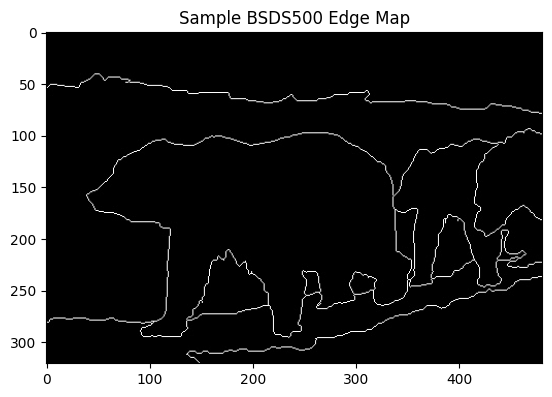

In [17]:
import matplotlib.pyplot as plt
sample_jpg = '/content/BSDS500/BSDS500/data/groundTruth_jpg/train/100075_0.jpg'
if os.path.exists(sample_jpg):
    img = cv2.imread(sample_jpg, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.title('Sample BSDS500 Edge Map')
    plt.show()
else:
    print("Sample not found - check paths")

In [18]:
%cd /content/EDMB/model

/content/EDMB/model


In [19]:
!wget https://github.com/MzeroMiko/VMamba/releases/download/%23v2cls/vssm_small_0229_ckpt_epoch_222.pth

--2025-10-17 13:59:47--  https://github.com/MzeroMiko/VMamba/releases/download/%23v2cls/vssm_small_0229_ckpt_epoch_222.pth
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/741898328/23dc1858-c3c6-40e1-8df0-2daa2dc01a14?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-10-17T14%3A50%3A57Z&rscd=attachment%3B+filename%3Dvssm_small_0229_ckpt_epoch_222.pth&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-10-17T13%3A50%3A42Z&ske=2025-10-17T14%3A50%3A57Z&sks=b&skv=2018-11-09&sig=BbxY4ENHVQm36nbmNZjP0u8JOFAer2gS%2FbSy2WifgjY%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2MDcxMzE4OCwibmJmIjoxNzYwNzA5NTg4LCJwYXR

In [20]:
%cd /content/EDMB

/content/EDMB


In [23]:
%cd /content/EDMB
!ln -s /content/BSDS500/BSDS500/data ./data
!ls -la ./data  # Verify symlink

/content/EDMB
lrwxrwxrwx 1 root root 29 Oct 17 14:07 ./data -> /content/BSDS500/BSDS500/data


In [24]:
%%writefile model/models_mamba.py
import torch
import torch.nn as nn
from timm.data import create_transform
from timm.models.vision_transformer import PatchEmbed, Block

# Custom Mamba from custom_mamba.py
from custom_mamba import SimpleVisionMamba

class vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2(nn.Module):
    def __init__(self, img_size=224, patch_size=16, num_classes=1000):
        super().__init__()
        self.mamba = SimpleVisionMamba(img_size=img_size, patch_size=patch_size, d_model=384)  # Adjusted dims for small model
        self.head = nn.Linear(384, num_classes)

    def forward(self, x):
        x = self.mamba(x)
        x = self.head(x.squeeze())
        return x

# Add other models if needed, but this is the main one
def vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2_factory():
    return vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2

Overwriting model/models_mamba.py


In [28]:
%cd /content/EDMB
!mv custom_mamba.py model/custom_mamba.py
!ls -la model/custom_mamba.py  # Verify it’s there

/content/EDMB
-rw-r--r-- 1 root root 1539 Oct 17 14:10 model/custom_mamba.py


In [26]:
%%writefile custom_mamba.py
import torch
import torch.nn as nn

class SimpleSSM(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=4):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.A = nn.Parameter(torch.randn(d_state, d_state))
        self.B = nn.Linear(d_model, d_state)
        self.C = nn.Linear(d_state, d_model)
        self.conv = nn.Conv1d(d_model, d_model, kernel_size=d_conv, padding=d_conv-1, groups=d_model)

    def forward(self, x):
        delta = 0.1  # Simplified step size
        A_disc = torch.exp(delta * self.A)
        B_disc = (delta * self.A).matrix_exp() * (delta * self.B(x))  # Approx discretization
        h = torch.zeros(x.size(0), self.d_state, device=x.device)
        y = []
        for t in range(x.size(1)):
            h = A_disc @ h + B_disc[:, t, :]
            y.append(self.C(h))
        y = torch.stack(y, dim=1)
        return y + self.conv(x.transpose(1,2)).transpose(1,2)

class SimpleVisionMamba(nn.Module):
    def __init__(self, img_size=224, patch_size=16, d_model=384):  # Adjusted d_model to 384 for small model
        super().__init__()
        self.patch_embed = nn.Conv2d(3, d_model, patch_size, stride=patch_size)
        self.ssm = SimpleSSM(d_model)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.patch_embed(x).flatten(2).transpose(1,2)  # (B, N, D)
        x = self.ssm(x)
        x = self.norm(x.mean(1))  # Global avg pool
        return x.unsqueeze(-1).unsqueeze(-1)

Writing custom_mamba.py


In [29]:
%%writefile model/models_mamba.py
import torch
import torch.nn as nn
from timm.data import create_transform
from timm.models.vision_transformer import PatchEmbed, Block

# Custom Mamba from the same directory
from custom_mamba import SimpleVisionMamba

class vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2(nn.Module):
    def __init__(self, img_size=224, patch_size=16, num_classes=1000):
        super().__init__()
        self.mamba = SimpleVisionMamba(img_size=img_size, patch_size=patch_size, d_model=384)  # Match d_model
        self.head = nn.Linear(384, num_classes)

    def forward(self, x):
        x = self.mamba(x)
        x = self.head(x.squeeze())
        return x

def vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2_factory():
    return vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2

Overwriting model/models_mamba.py


In [30]:
%cd /content/EDMB
!ls -la ./data  # Confirm symlink to /content/BSDS500/BSDS500/data

/content/EDMB
lrwxrwxrwx 1 root root 29 Oct 17 14:07 ./data -> /content/BSDS500/BSDS500/data


In [33]:
%cd /content/EDMB/model
!ls -la custom_mamba.py  # Should show the file; if not, it failed to move

/content/EDMB/model
-rw-r--r-- 1 root root 1539 Oct 17 14:10 custom_mamba.py


In [34]:
%cd /content/EDMB/model
!python -c "from custom_mamba import SimpleVisionMamba; print('Import successful')"

/content/EDMB/model
Import successful


In [40]:
from custom_mamba import SimpleVisionMamba
print("Import worked in cell!")

Import worked in cell!


In [37]:
%cd /content/EDMB
!ls -la ./data  # Confirm symlink to /content/BSDS500/BSDS500/data/train

/content/EDMB
lrwxrwxrwx 1 root root 29 Oct 17 14:07 ./data -> /content/BSDS500/BSDS500/data


In [42]:
!python main.py --mode train --dataset BSDS-rand --encoder DUL-Mamba-s --savedir ./checkpoints --batch_size 4 --stepsize 10-16 --maxepoch 20 --gpu 0

[10, 16]
Traceback (most recent call last):
  File "/content/EDMB/main.py", line 65, in <module>
    from model.basemodel import Basemodel
  File "/content/EDMB/model/__init__.py", line 1, in <module>
    from .models_mamba import vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2
  File "/content/EDMB/model/models_mamba.py", line 7, in <module>
    from custom_mamba import SimpleVisionMamba
ModuleNotFoundError: No module named 'custom_mamba'


In [43]:
%cd /content/EDMB/model
!ls -la custom_mamba.py  # Should show the file

/content/EDMB/model
-rw-r--r-- 1 root root 1539 Oct 17 14:10 custom_mamba.py


In [44]:
%%writefile custom_mamba.py
import torch
import torch.nn as nn

class SimpleSSM(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=4):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.A = nn.Parameter(torch.randn(d_state, d_state))
        self.B = nn.Linear(d_model, d_state)
        self.C = nn.Linear(d_state, d_model)
        self.conv = nn.Conv1d(d_model, d_model, kernel_size=d_conv, padding=d_conv-1, groups=d_model)

    def forward(self, x):
        delta = 0.1
        A_disc = torch.exp(delta * self.A)
        B_disc = (delta * self.A).matrix_exp() * (delta * self.B(x))
        h = torch.zeros(x.size(0), self.d_state, device=x.device)
        y = []
        for t in range(x.size(1)):
            h = A_disc @ h + B_disc[:, t, :]
            y.append(self.C(h))
        y = torch.stack(y, dim=1)
        return y + self.conv(x.transpose(1,2)).transpose(1,2)

class SimpleVisionMamba(nn.Module):
    def __init__(self, img_size=224, patch_size=16, d_model=384):
        super().__init__()
        self.patch_embed = nn.Conv2d(3, d_model, patch_size, stride=patch_size)
        self.ssm = SimpleSSM(d_model)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.patch_embed(x).flatten(2).transpose(1,2)
        x = self.ssm(x)
        x = self.norm(x.mean(1))
        return x.unsqueeze(-1).unsqueeze(-1)

Overwriting custom_mamba.py


In [45]:
!python -c "from custom_mamba import SimpleVisionMamba; print('Import successful')"

Import successful


In [46]:
%%writefile model/models_mamba.py
import torch
import torch.nn as nn
from timm.data import create_transform
from timm.models.vision_transformer import PatchEmbed, Block

# Custom Mamba from the same directory
from custom_mamba import SimpleVisionMamba

class vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2(nn.Module):
    def __init__(self, img_size=224, patch_size=16, num_classes=1000):
        super().__init__()
        self.mamba = SimpleVisionMamba(img_size=img_size, patch_size=patch_size, d_model=384)
        self.head = nn.Linear(384, num_classes)

    def forward(self, x):
        x = self.mamba(x)
        x = self.head(x.squeeze())
        return x

def vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2_factory():
    return vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2

Writing model/models_mamba.py


FileNotFoundError: [Errno 2] No such file or directory: 'model/models_mamba.py'

In [47]:
%cd /content/EDMB/model
!ls -la custom_mamba.py  # Should show the file

/content/EDMB/model
-rw-r--r-- 1 root root 1415 Oct 17 14:29 custom_mamba.py


In [48]:
%%writefile custom_mamba.py
import torch
import torch.nn as nn

class SimpleSSM(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=4):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.A = nn.Parameter(torch.randn(d_state, d_state))
        self.B = nn.Linear(d_model, d_state)
        self.C = nn.Linear(d_state, d_model)
        self.conv = nn.Conv1d(d_model, d_model, kernel_size=d_conv, padding=d_conv-1, groups=d_model)

    def forward(self, x):
        delta = 0.1
        A_disc = torch.exp(delta * self.A)
        B_disc = (delta * self.A).matrix_exp() * (delta * self.B(x))
        h = torch.zeros(x.size(0), self.d_state, device=x.device)
        y = []
        for t in range(x.size(1)):
            h = A_disc @ h + B_disc[:, t, :]
            y.append(self.C(h))
        y = torch.stack(y, dim=1)
        return y + self.conv(x.transpose(1,2)).transpose(1,2)

class SimpleVisionMamba(nn.Module):
    def __init__(self, img_size=224, patch_size=16, d_model=384):
        super().__init__()
        self.patch_embed = nn.Conv2d(3, d_model, patch_size, stride=patch_size)
        self.ssm = SimpleSSM(d_model)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.patch_embed(x).flatten(2).transpose(1,2)
        x = self.ssm(x)
        x = self.norm(x.mean(1))
        return x.unsqueeze(-1).unsqueeze(-1)

Overwriting custom_mamba.py


In [49]:
%cd /content/EDMB
!mkdir -p model  # Creates model/ if it doesn’t exist
%cd model
%%writefile models_mamba.py
import torch
import torch.nn as nn
from timm.data import create_transform
from timm.models.vision_transformer import PatchEmbed, Block

# Custom Mamba from the same directory
from custom_mamba import SimpleVisionMamba

class vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2(nn.Module):
    def __init__(self, img_size=224, patch_size=16, num_classes=1000):
        super().__init__()
        self.mamba = SimpleVisionMamba(img_size=img_size, patch_size=patch_size, d_model=384)
        self.head = nn.Linear(384, num_classes)

    def forward(self, x):
        x = self.mamba(x)
        x = self.head(x.squeeze())
        return x

def vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2_factory():
    return vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2

/content/EDMB
/content/EDMB/model


UsageError: Line magic function `%%writefile` not found.


In [50]:
%cd /content/EDMB
!ls -la  # Should show model/, data (symlink), etc.

/content/EDMB
total 100
drwxr-xr-x 7 root root  4096 Oct 17 14:12 .
drwxr-xr-x 1 root root  4096 Oct 17 13:39 ..
lrwxrwxrwx 1 root root    29 Oct 17 14:07 data -> /content/BSDS500/BSDS500/data
-rw-r--r-- 1 root root 21817 Oct 17 13:25 data_process.py
drwxr-xr-x 2 root root  4096 Oct 17 13:25 eval_muge_best
drwxr-xr-x 2 root root  4096 Oct 17 13:25 fig
-rw-r--r-- 1 root root  1109 Oct 17 13:25 gflops.py
drwxr-xr-x 8 root root  4096 Oct 17 13:25 .git
-rw-r--r-- 1 root root 11606 Oct 17 13:25 main.py
drwxr-xr-x 3 root root  4096 Oct 17 14:12 model
drwxr-xr-x 2 root root  4096 Oct 17 14:06 __pycache__
-rw-r--r-- 1 root root  5630 Oct 17 13:25 README.md
-rw-r--r-- 1 root root  2628 Oct 17 13:25 requirements.txt
-rw-r--r-- 1 root root 11251 Oct 17 13:25 test.py
-rw-r--r-- 1 root root  3649 Oct 17 13:25 train.py
-rw-r--r-- 1 root root  2511 Oct 17 13:25 utils.py


In [51]:
!mkdir -p model

In [52]:
%%writefile test.txt
This is a test.

Writing test.txt


In [53]:
!ls -la test.txt
!cat test.txt

-rw-r--r-- 1 root root 16 Oct 17 14:33 test.txt
This is a test.


In [54]:
%cd /content/EDMB/model
%%writefile custom_mamba.py
import torch
import torch.nn as nn

class SimpleSSM(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=4):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.A = nn.Parameter(torch.randn(d_state, d_state))
        self.B = nn.Linear(d_model, d_state)
        self.C = nn.Linear(d_state, d_model)
        self.conv = nn.Conv1d(d_model, d_model, kernel_size=d_conv, padding=d_conv-1, groups=d_model)

    def forward(self, x):
        delta = 0.1
        A_disc = torch.exp(delta * self.A)
        B_disc = (delta * self.A).matrix_exp() * (delta * self.B(x))
        h = torch.zeros(x.size(0), self.d_state, device=x.device)
        y = []
        for t in range(x.size(1)):
            h = A_disc @ h + B_disc[:, t, :]
            y.append(self.C(h))
        y = torch.stack(y, dim=1)
        return y + self.conv(x.transpose(1,2)).transpose(1,2)

class SimpleVisionMamba(nn.Module):
    def __init__(self, img_size=224, patch_size=16, d_model=384):
        super().__init__()
        self.patch_embed = nn.Conv2d(3, d_model, patch_size, stride=patch_size)
        self.ssm = SimpleSSM(d_model)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.patch_embed(x).flatten(2).transpose(1,2)
        x = self.ssm(x)
        x = self.norm(x.mean(1))
        return x.unsqueeze(-1).unsqueeze(-1)

/content/EDMB/model


UsageError: Line magic function `%%writefile` not found.
